# Implementation of Heart Disease Classification

This notebook walks through the complete workflow of a project, focusing on implementation of data preparation, visualizations, preprocessing and modeling. 

See the report for insights and outcomes description.

---

## Table of Contents

1. [Environment Setup](#Environment-Setup)
2. [Data Ingestion](#Data-Ingestion)
3. [Data Preparation](#Data-Preparation)
    - 3.1 [Handling Missing Values](#Handling-Missing-Values)
    - 3.2 [Change Data Types](#Change-Data-Types)
    - 3.3 [Change `thal` structure](#Change-thal-structure)
    - 3.4 [Simplify Targets](#Simplify-Targets)
4. [Exploratory Data Analysis](#Exploratory-Data-Analysis)
    - 4.1 [Proportion of outcomes](#Proportion-of-outcomes)
    - 4.2 [Sex cardiovascular possibilities](#Sex-cardiovascular-possibilities)
    - 4.3 [Age proportions](#Age-proportions)
    - 4.4 [Distributions of features](#Distributions-of-features)
    - 4.5 [Outliers in numerical variables](#Outliers-in-numerical-variables)
    - 4.6 [Correlation between variables](#Correlation-between-variables)
    - 4.7 [Implication of major vessels visibility on heart disease](#Implication-of-major-vessels-visibility-on-heart-disease)
5. [Hypothesis Testing](#Hypothesis-Testing)
6. [Preprocessing](#Preprocessing)
7. [Modeling](#Modeling)
8. [Evaluation](#Evaluation)
   - 8.1 [Metrics](#Metrics)
   - 8.2 [Confusion Matrices](#Confusion-Matrices)
   - 8.3 [ROC Curves](#ROC-Curves)
   - 8.4 [Cross Validation](#Cross-Validation)

---
## Environment Setup

In [1]:
# This cell imports the core libraries used in this project.
# - pandas: for data loading and manipulation
# - numpy: for numeric processing
# - matplotlib.pyplot: for plotting
# - scikit-learn: for preprocessing, model building, and evaluation metrics
# - scipy: for statistical operations

import os
import numpy as np
import pandas as pd
from datetime import datetime as dt
from matplotlib import cm
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
from statsmodels.graphics.mosaicplot import mosaic


from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, RobustScaler

from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import VotingClassifier

from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             confusion_matrix, classification_report, roc_curve, auc,
                             RocCurveDisplay, roc_auc_score)


---
## Data Ingestion

In [2]:
try: 
    import ucimlrepo as uci
    heart_disease = uci.fetch_ucirepo(id=45) 

    X = heart_disease.data.features 
    y = heart_disease.data.targets 

    df = heart_disease.data.original
except:
    url = "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data"

    df = pd.read_csv(
        url, # In case of library absence, specify path to the dataset
        header=None,
    )
    df = df.replace('?', np.nan)

# Column names based on the UCI Heart Disease (Cleveland) documentation
column_names = [
    "age",       # 0 
    "sex",       # 1 - (0 = female, 1 = male)
    "cp",        # 2 - chest pain type (1 = typical angina, 2 = atypical angina, 3 = non-anginal pain, 4 = asymptomatic)
    "trestbps",  # 3 - resting blood pressure
    "chol",      # 4 - serum cholesterol
    "fbs",       # 5 - fasting blood sugar > 120 mg/dl (0 = false; 1 = true)
    "restecg",   # 6 - resting ECG (0 = normal, 
                 #                  1 = having ST-T wave abnormality, 
                 #                  2 = showing probable or definite left ventricular hypertrophy by Estes' criteria)
    "thalach",   # 7 - max heart rate
    "exang",     # 8 - exercise induced angina (0 = no; 1 = yes)
    "oldpeak",   # 9 - ST depression
    "slope",     # 10 - slope of ST segment (1 = upsloping, 2 = flat, 3 = downsloping)
    "ca",        # 11 - number of major vessels
    "thal",      # 12 - thalassemia (3 = normal, 6 = fixed defect, 7 = reversable defect)
    "target"        # 13 - diagnosis (0 = no disease, 1–4 = disease)
]

df = df.rename(columns=dict(zip(df.columns, column_names)))
df.head()


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
1,67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,2
2,67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
3,37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0,0
4,41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0,0


---
## Data Preparation

At this point, we are interested in inspecting our dataset for any inconsistencies in features description or logical representation, missing values, incorrect data types, etc. 

Since dataset we are using was processed and has a good quality, some superficial examination will be enough for this step.

In [3]:
categorical = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal', 'target']
numerical = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']


In [4]:
df.describe(include='all').T

,count,mean,std,min,25%,50%,75%,max
age,303.0,54.438944,9.038662,29.0,48.0,56.0,61.0,77.0
sex,303.0,0.679868,0.467299,0.0,0.0,1.0,1.0,1.0
cp,303.0,3.158416,0.960126,1.0,3.0,3.0,4.0,4.0
trestbps,303.0,131.689769,17.599748,94.0,120.0,130.0,140.0,200.0
chol,303.0,246.693069,51.776918,126.0,211.0,241.0,275.0,564.0
fbs,303.0,0.148515,0.356198,0.0,0.0,0.0,0.0,1.0
restecg,303.0,0.990099,0.994971,0.0,0.0,1.0,2.0,2.0
thalach,303.0,149.607261,22.875003,71.0,133.5,153.0,166.0,202.0
exang,303.0,0.326733,0.469794,0.0,0.0,0.0,1.0,1.0
oldpeak,303.0,1.039604,1.161075,0.0,0.0,0.8,1.6,6.2


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        299 non-null    float64
 12  thal      301 non-null    float64
 13  target    303 non-null    int64  
dtypes: float64(3), int64(11)
memory usage: 33.3 KB


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        299 non-null    float64
 12  thal      301 non-null    float64
 13  target    303 non-null    int64  
dtypes: float64(3), int64(11)
memory usage: 33.3 KB


In [7]:
# To check correctness of categorical sequence
df[categorical].agg(['min', 'max'])

,sex,cp,fbs,restecg,exang,slope,ca,thal,target
min,0,1,0,0,0,1,0.0,3.0,0
max,1,4,1,2,1,3,3.0,7.0,4


A preliminary examination of the dataset reveals several issues:
- The ca and thal columns are indicating missing or invalid values that need to be addressed.

- Several categorical features are currently treated as numerical, so their data types should be corrected to ensure proper categorical handling.

- The `thal` variable displays an irregular category structure. Since the ordering has no domain-specific meaning, it should be standardized or re-encoded.

- Because the goal is to predict the presence of heart disease rather than its severity, the multi-class categories (1–4) describing disease type can be simplified into a binary indicator. 

### Handling Missing Values

In [8]:
na = df[df.isna().any(axis=1)]

print(f'Percentage of rows with missing values: {round(len(na)/len(df) * 100,2)}%')
na

Percentage of rows with missing values: 1.98%


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
87,53,0,3,128,216,0,2,115,0,0.0,1,0.0,NaN,0
166,52,1,3,138,223,0,0,169,0,0.0,1,NaN,3.0,0
192,43,1,4,132,247,1,2,143,1,0.1,2,NaN,7.0,1
266,52,1,4,128,204,1,0,156,1,1.0,2,0.0,NaN,2
287,58,1,2,125,220,0,0,144,0,0.4,2,NaN,7.0,0
302,38,1,3,138,175,0,0,173,0,0.0,1,NaN,3.0,0


Since proportion of rows with missing values is relatively low to whole dataset, we can afford to just drop them.

In [9]:
na

dfc = df.dropna(ignore_index=True)
dfc

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
1,67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,2
2,67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
3,37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0,0
4,41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
292,57,0,4,140,241,0,0,123,1,0.2,2,0.0,7.0,1
293,45,1,1,110,264,0,0,132,0,1.2,2,0.0,7.0,1
294,68,1,4,144,193,1,0,141,0,3.4,2,2.0,7.0,2
295,57,1,4,130,131,0,0,115,1,1.2,2,1.0,7.0,3


### Change Data Types

In [10]:
dfc = dfc.astype({c: 'category' for c in categorical})

dfc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 297 entries, 0 to 296
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   age       297 non-null    int64   
 1   sex       297 non-null    category
 2   cp        297 non-null    category
 3   trestbps  297 non-null    int64   
 4   chol      297 non-null    int64   
 5   fbs       297 non-null    category
 6   restecg   297 non-null    category
 7   thalach   297 non-null    int64   
 8   exang     297 non-null    category
 9   oldpeak   297 non-null    float64 
 10  slope     297 non-null    category
 11  ca        297 non-null    category
 12  thal      297 non-null    category
 13  target    297 non-null    category
dtypes: category(9), float64(1), int64(4)
memory usage: 15.7 KB


### Change `thal` structure

In [11]:
dfc['thal'].unique()

[6.0, 3.0, 7.0]
Categories (3, float64): [3.0, 6.0, 7.0]

In [12]:
dfc['thal'] = dfc['thal'].cat.rename_categories([1, 2, 3])

dfc['thal']

0      2
1      1
2      3
3      1
4      1
      ..
292    3
293    3
294    3
295    3
296    1
Name: thal, Length: 297, dtype: category
Categories (3, int64): [1, 2, 3]

### Simplify Targets

In [13]:
dfc['target'] = (dfc['target'] != 0)

dfc['target']

0      False
1       True
2       True
3      False
4      False
       ...  
292     True
293     True
294     True
295     True
296     True
Name: target, Length: 297, dtype: bool

---
## Exploratory Data Analysis

As the point of our exploration, we want to inspect how balanced our dataset, conduct univariate and multivariate analyses to gather any insights than can help us to build efficient predictive model later on.

### Proportion of outcomes

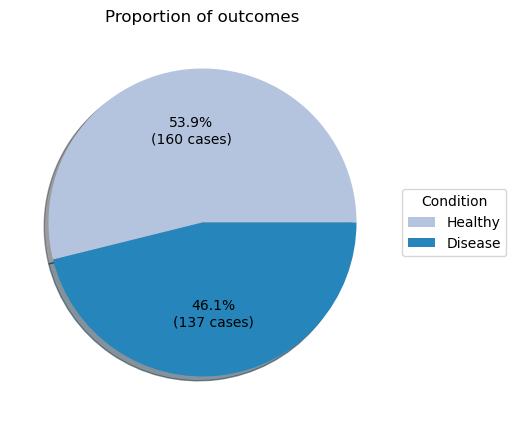

In [14]:
def calc_pct(pct, allvals):
    absolute = int(np.round(pct/100.*np.sum(allvals)))
    return f"{pct:.1f}%\n({absolute:d} cases)"

t = dfc['target'].value_counts().reset_index()
colors = sns.color_palette('PuBu', len(t))

fig, ax = plt.subplots(figsize=(10,5))
wedges, texts, autotexts = ax.pie(
    t['count'],
    colors=colors,
    shadow=True,
    autopct=lambda pct: calc_pct(pct, t['count'])
    
);

ax.legend(
    wedges,
    ['Healthy', 'Disease'],
    title="Condition",
    loc="center left",
    bbox_to_anchor=(1, 0, 0.5, 1)
);

ax.set_title('Proportion of outcomes');
plt.savefig('artifacts/proportion-of-outcomes.png')

Our dataset is balanced enough to proceed without any further actions.

### Sex cardiovascular possibilities

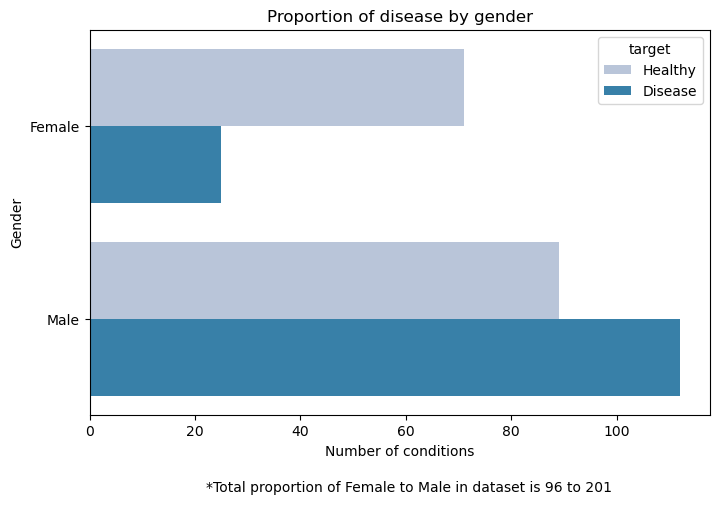

In [15]:
t = dfc.groupby(['sex', 'target'], observed=True)['target'].value_counts().reset_index()
t.sex = t.sex.cat.rename_categories(['Female', 'Male'])
t.target = t.target.replace({False:'Healthy', True:'Disease'})

fig, ax = plt.subplots(figsize=(8,5))

sns.barplot(data=t, x='count', y='sex', orient='h', hue='target', palette='PuBu', ax=ax);

ax.text(
    22,
    1.9,
    f"*Total proportion of Female to Male in dataset is {dfc[dfc.sex == 0].sex.count()} to {dfc[dfc.sex == 1].sex.count()}",
)

plt.ylabel('Gender');
plt.xlabel('Number of conditions');
plt.title('Proportion of disease by gender');
plt.savefig('artifacts/proportion-of-disease-by-gender.png')

### Age proportions

In [16]:
t = dfc.copy()
t['age_group'] = pd.cut(t['age'], bins=[x*10 for x in range(2, 9)])


In [17]:
t = t.groupby(['age_group', 'target'], observed=True)['target'].value_counts().reset_index()
t.target = t.target.replace({False:'Healthy', True:'Disease'})


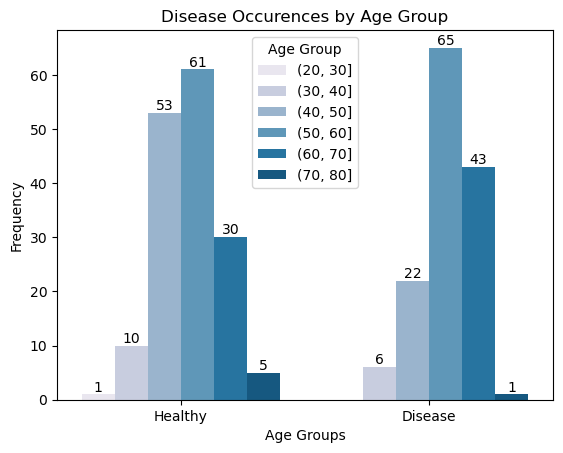

In [18]:
ax = sns.barplot(data=t, x='target', y='count', hue='age_group', palette='PuBu', orient='v');
plt.xlabel('Age Groups')
plt.ylabel('Frequency')
plt.title('Disease Occurences by Age Group')

intervals = t['age_group'].values.unique()
plt.legend(
    title='Age Group'
)

for container in ax.containers:
    ax.bar_label(container)

plt.savefig('artifacts/disease-occurences-by-age-group.png')

### Distributions of features

In [19]:
def plot_dataframe_distributions(df, ncols=4, nrows=4, figsize=(20, 10)):
    num_cols = len(df.columns)
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize, constrained_layout=True)
    axes = axes.flatten()[:num_cols]  
    
    for i, (col, ax) in enumerate(zip(df.columns, axes)):
        sns.histplot(data=df, x=col, kde=True, ax=ax, color='cornflowerblue')
        ax.set_title(col)
    
    if num_cols < len(axes):
        for j in range(num_cols, len(axes)):
            fig.delaxes(axes[j])

    fig.suptitle('Distributions', fontsize=16)
    plt.show()

    fig.savefig(f'artifacts/distributions{dt.now().strftime('%Y%m%d_%H%M%S_%f')}.png')

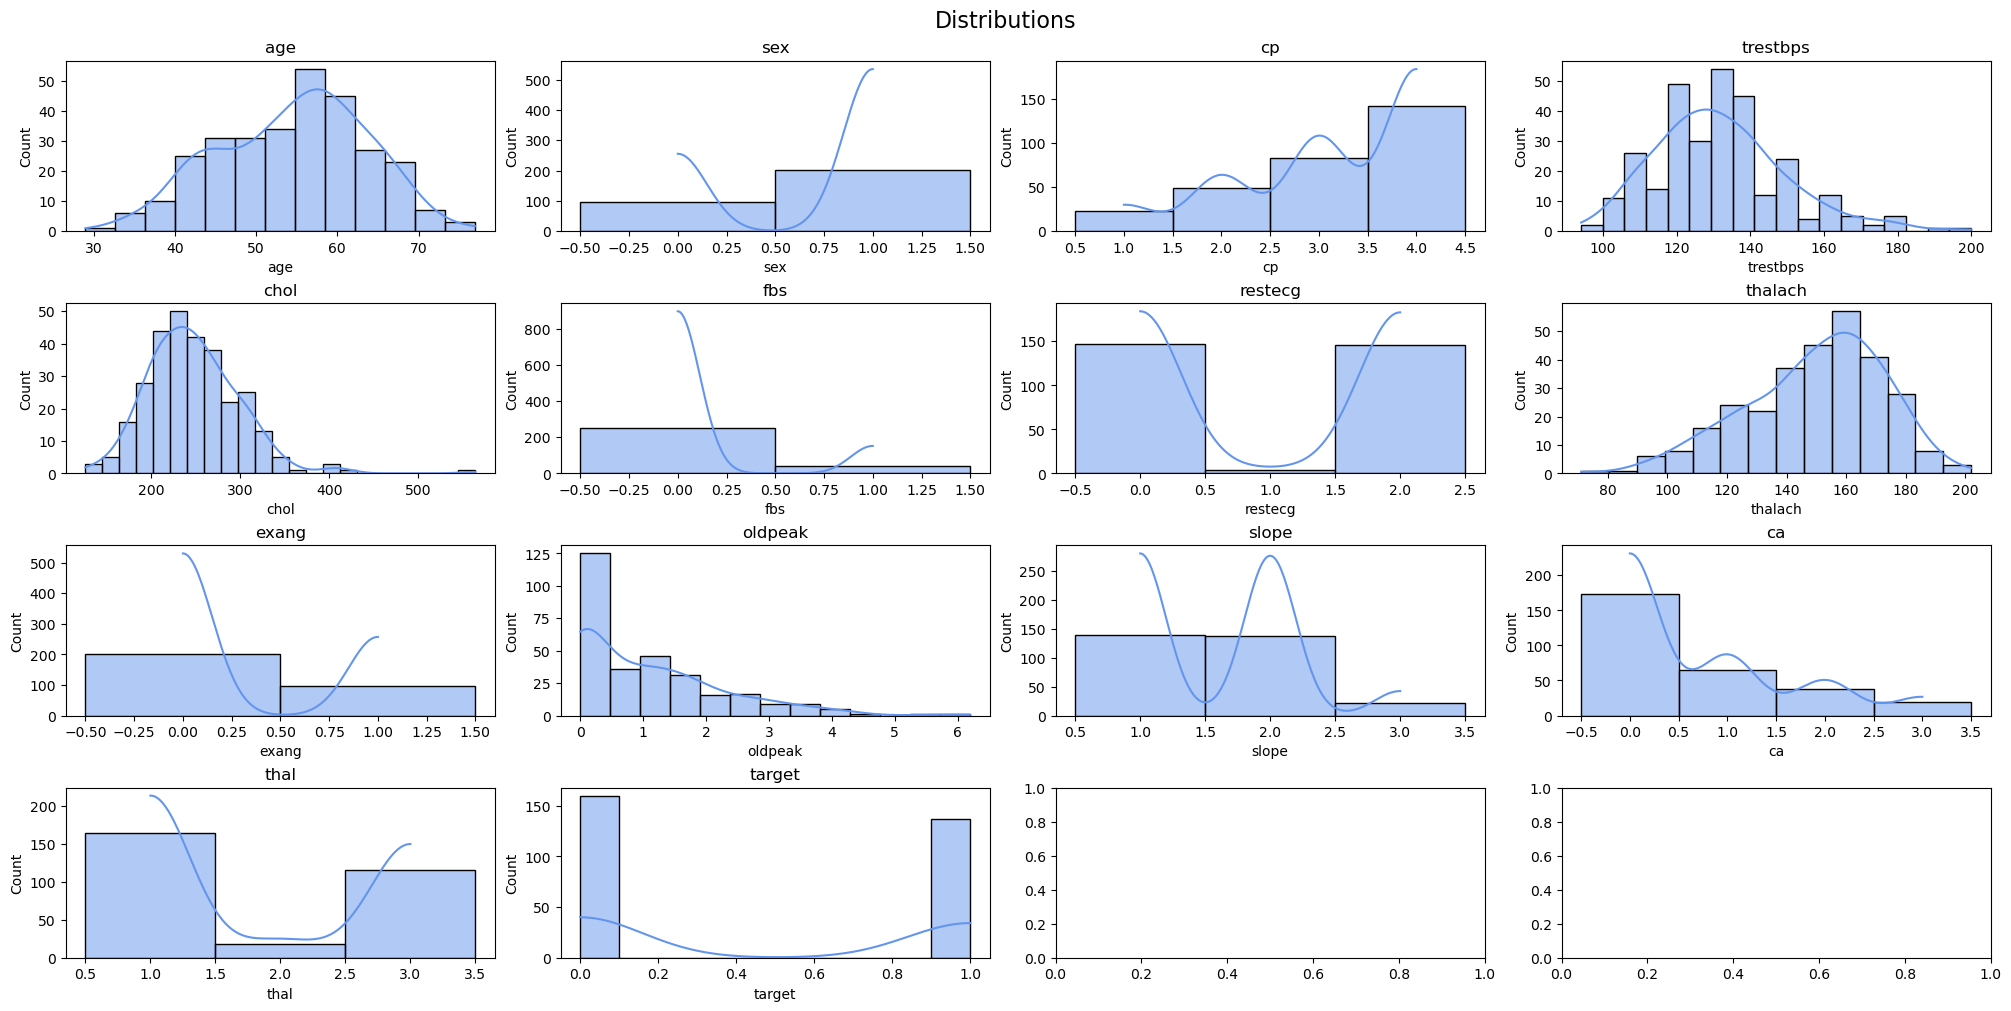

In [20]:
plot_dataframe_distributions(dfc)

Distribution of total cholesterol level - 'chol' clearly shows us a presense of outliers.

Features as `trestbps`, `chol`, `thalach` is moderately skewed, while `oldpeak` is extremely right-skewed.

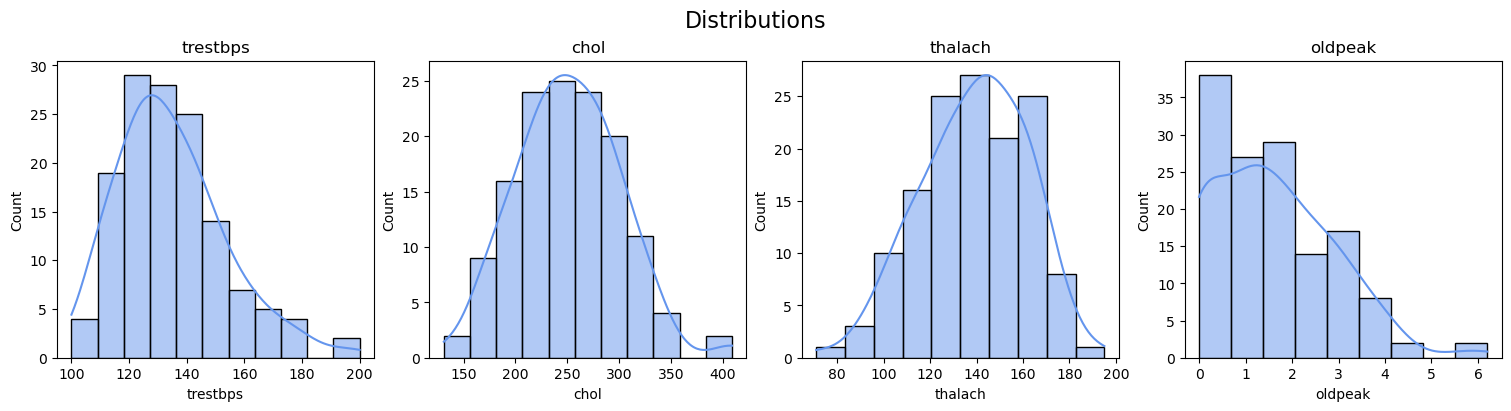

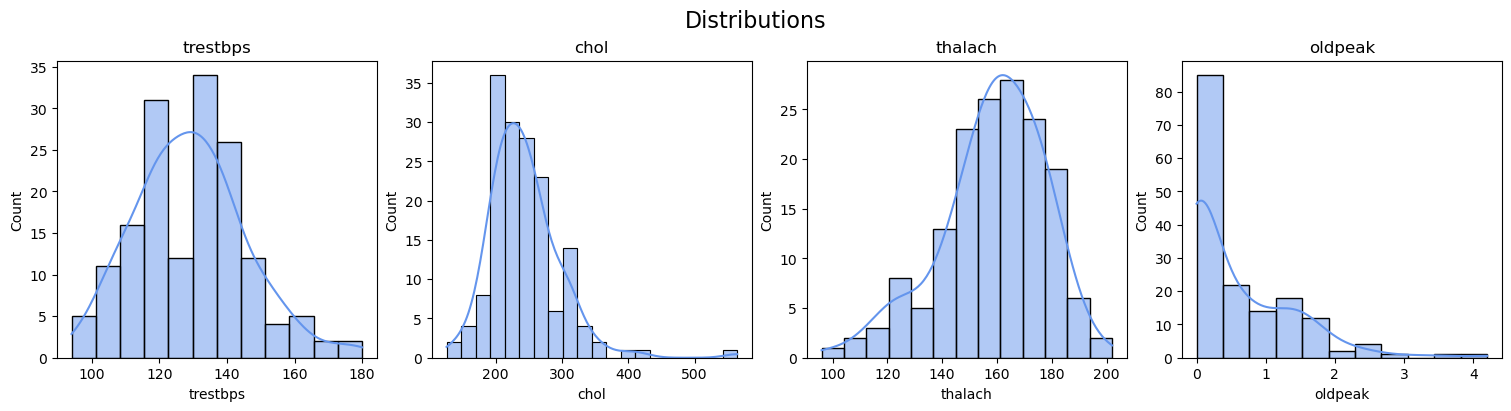

In [21]:
num_disease = dfc[dfc['target'] == 1][['trestbps', 'chol', 'thalach', 'oldpeak']]
num_healthy = dfc[dfc['target'] == 0][['trestbps', 'chol', 'thalach', 'oldpeak']]

plot_dataframe_distributions(num_disease, ncols=4, nrows=1, figsize=(15,4))
plot_dataframe_distributions(num_healthy, ncols=4, nrows=1, figsize=(15,4))

### Outliers in numerical variables

In [22]:
def plot_outliers(data, width=0.8, palette=None, color=None):
    plt.figure(figsize=(9, 5))
    ax = sns.boxplot(data=data, width=width, palette=palette, color=color)
    plt.title('Outliers')
    plt.show();

    ax.get_figure().savefig(f'artifacts/outliers{dt.now().strftime('%Y%m%d_%H%M%S_%f')}.png')

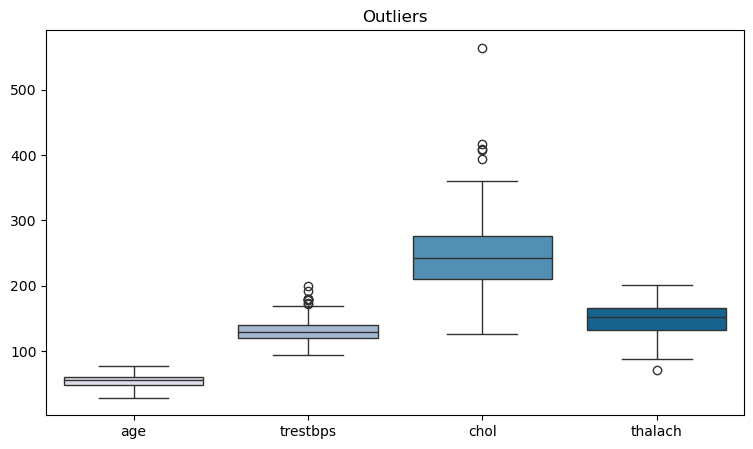

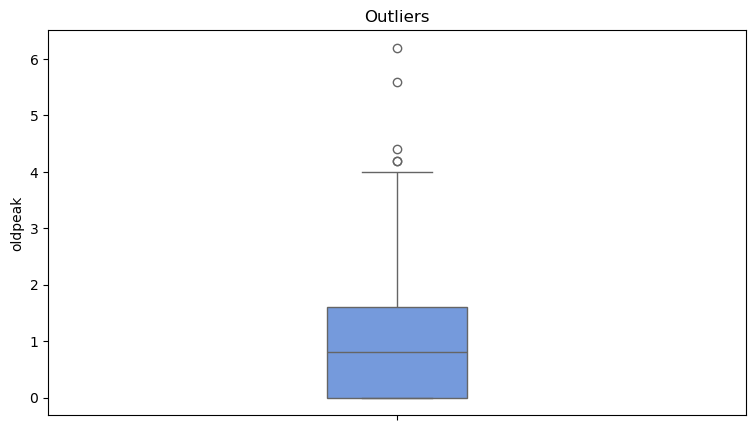

In [23]:
plot_outliers(dfc[numerical].drop('oldpeak', axis=1), palette='PuBu')
plot_outliers(dfc['oldpeak'], width=0.2, color='cornflowerblue')


Here we can confirm presence of extreme outlier in 'chol' and observe values that skew `trestbps`, `thalach` and `oldpeak`.

### Correlation between variables

In [24]:
def plot_correlation_heatmap(data):
    cor = data.corr()  
    mask = np.zeros_like(cor)
    mask[np.triu_indices_from(mask)] = True # returns indices of upper triangle of a matrix
    ax = plt.figure(figsize=(16, 7))
    sns.heatmap(cor,
                fmt='.3f',
                cmap='PuBu', 
                annot=True,
                mask=mask)
    plt.title('Correlation Heatmap')
    plt.show()

    ax.savefig(f'artifacts/corr{dt.now().strftime('%Y%m%d_%H%M%S_%f')}.png')

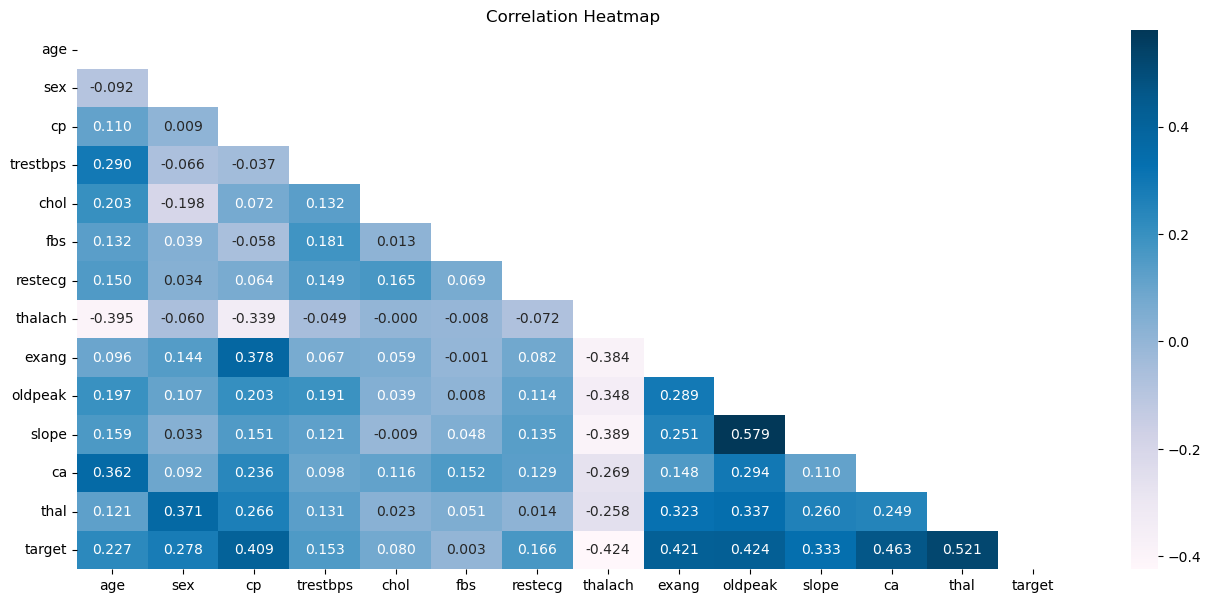

In [25]:
plot_correlation_heatmap(dfc)


Here we can see a strong correlation between heart disease and features like:
- chest pain
- excercise enduced angina
- ST depression
- number of major vessels
- thalassemia

Those features have a highest impact on our predictions, so it's worth to explore them and gather them more thoroughly in the future.

### Implication of major vessels visibility on heart disease

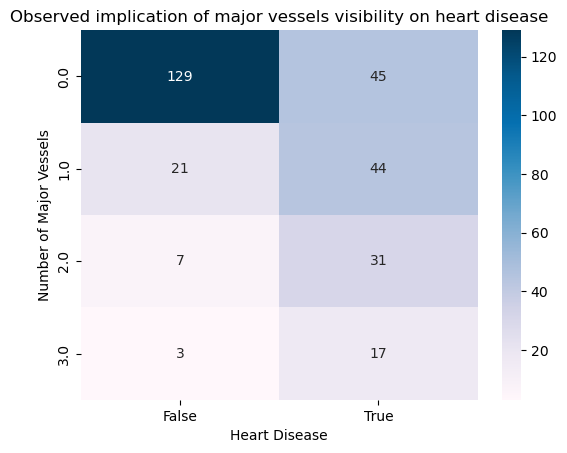

In [26]:
ct = pd.crosstab(dfc['ca'], dfc['target'])

ax = sns.heatmap(
    ct,
    annot=True,
    cmap='PuBu',
    fmt='d'
)

plt.xlabel("Heart Disease")
plt.ylabel("Number of Major Vessels")
plt.title("Observed implication of major vessels visibility on heart disease")

plt.show()
ax.get_figure().savefig('artifacts/major-vessels-heart-disease.png')

---
## Hypothesis Testing

In [27]:
r = st.chi2_contingency(ct)
r

Chi2ContingencyResult(statistic=72.30053062466945, pvalue=1.37257765344901e-15, dof=3, expected_freq=array([[93.73737374, 80.26262626],
       [35.01683502, 29.98316498],
       [20.47138047, 17.52861953],
       [10.77441077,  9.22558923]]))

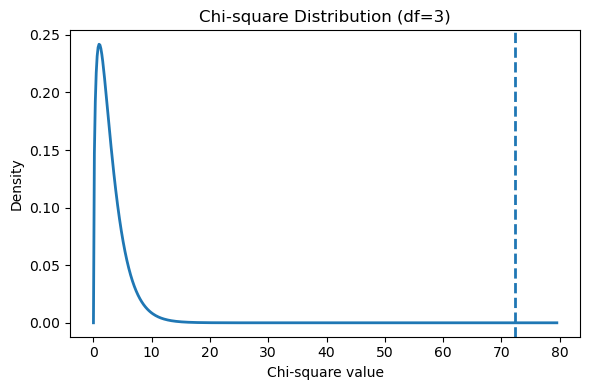

In [28]:
x = np.linspace(0, r[0] * 1.1, 500)
y = st.chi2.pdf(x, r[2])

fig = plt.figure(figsize=(6,4))
plt.plot(x, y, linewidth=2)
plt.axvline(r[0], linestyle="--", linewidth=2)
plt.xlabel("Chi-square value")
plt.ylabel("Density")
plt.title(f"Chi-square Distribution (df={r[2]})")
plt.tight_layout()
plt.show()
fig.savefig('artifacts/chi2.png')

---
## Preprocessing

In [29]:
X = dfc.drop(columns=['target'])
y = dfc['target']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    random_state=42,
    stratify=y 
)

In [30]:
numerical = X.select_dtypes(include=['int64', 'float64']).columns
categorical = X.select_dtypes(include=['category', 'bool']).columns


In [31]:
preprocessor = ColumnTransformer(
    transformers = [
        ('num', RobustScaler(), numerical),
        ('cat', OneHotEncoder(sparse_output=False), categorical) # some algorithms can't handle sparse matrices, as NB
    ],
    remainder='drop'
)

In [32]:
categorical

Index(['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal'], dtype='object')

It's worth mentioning, that we are using `RobustScaler` to scale our variables with median and interquantile range, which will help to prevent outliers and skeweness from affecting our models much, especially Naive Bayes.

Since we are using Gaussian Naive Bayes, those outliers and skeweness are violate core assumption of this algorithm - that each predictor follows a normal distribution within each class.

---
## Modeling

In [33]:
lr = LogisticRegression(max_iter=1000)
gnb = GaussianNB()

In [34]:
classification_models = {
    "Logistic Regression": lr,
    "Gaussian Naive Bayes": gnb
}

In [35]:
results = []
models = []

for name, clf in classification_models.items():
    print(f"Model: {name} trained")

    model_pipeline = Pipeline(
        steps=[
            ("preprocess", preprocessor),
            ("model", clf)
        ]
    )

    model_pipeline.fit(X_train, y_train)

    y_pred = model_pipeline.predict(X_test)

    y_scores = model_pipeline.predict_proba(X_test)[:, 1]
    roc_auc = roc_auc_score(y_test, y_scores)

    acc = accuracy_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    
    results.append(
        {
            "model_name": name,
            "model": model_pipeline,
            "X_test": X_test,
            "y_test": y_test,
            "acc": acc,
            "y_pred": y_pred,
            "y_scores": y_scores,
            "roc_auc": roc_auc,
            "cm": cm
        }
    )

Model: Logistic Regression trained
Model: Gaussian Naive Bayes trained


---
## Evaluation

### Metrics

In [36]:
def evaluate(results):
    for r in results:
        print('=' * 80)
        print(f"Model: {name}")
        print(f'{X_train.columns}\n')
        
        print(f'Accuracy: {r['acc']:.4f}')
        print(f'ROC-AUC: {r['roc_auc']:.4f}')
    
        print('\nClassification report:')
        print(classification_report(r['y_test'], r['y_pred']))

In [37]:
evaluate(results)


Model: Gaussian Naive Bayes
Index(['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach',
       'exang', 'oldpeak', 'slope', 'ca', 'thal'],
      dtype='object')

Accuracy: 0.8333
ROC-AUC: 0.9325

Classification report:
              precision    recall  f1-score   support

       False       0.81      0.90      0.85        48
        True       0.86      0.76      0.81        42

    accuracy                           0.83        90
   macro avg       0.84      0.83      0.83        90
weighted avg       0.84      0.83      0.83        90

Model: Gaussian Naive Bayes
Index(['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach',
       'exang', 'oldpeak', 'slope', 'ca', 'thal'],
      dtype='object')

Accuracy: 0.8556
ROC-AUC: 0.9469

Classification report:
              precision    recall  f1-score   support

       False       0.82      0.94      0.87        48
        True       0.91      0.76      0.83        42

    accuracy                           

### Confusion Matrices

In [38]:
def plot_confusion_matrices(results, nrows=1, ncols=2, figsize=(15, 5)):
    fig, axes = plt.subplots(
        nrows=nrows,
        ncols=ncols,
        figsize=figsize
    )

    axes = np.array(axes).ravel()

    for i, (r, ax) in enumerate(zip(results, axes)): 
        sns.heatmap(r['cm'], ax=ax, annot=True, cmap='PuBu')
        ax.set_title(r['model_name'])
        
    fig.suptitle("Confusion Matrices", fontsize=16)
    plt.show()
    fig.savefig('artifacts/confusion_matrices.png')

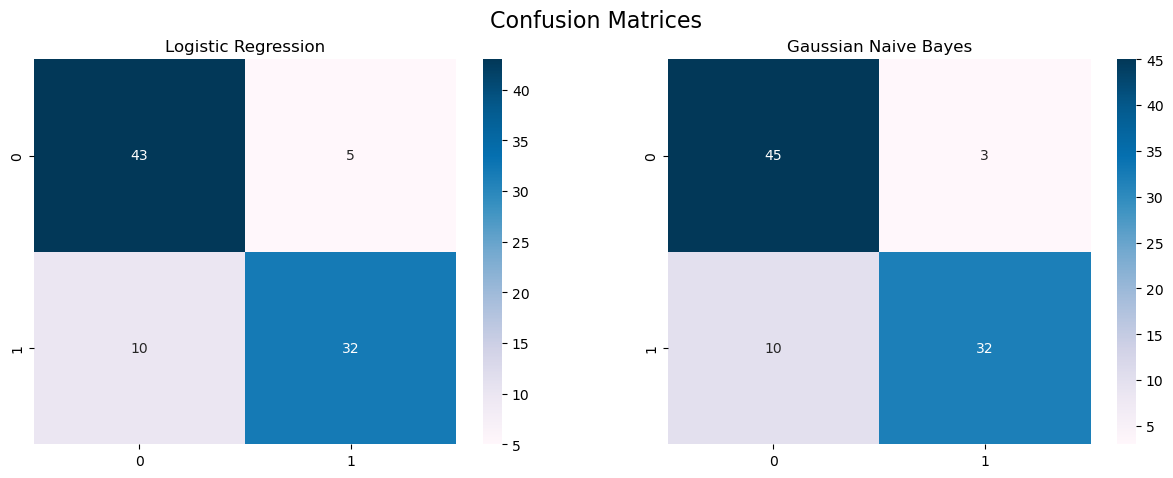

In [39]:
plot_confusion_matrices(results)


### ROC Curves

In [40]:
def plot_roc_curves(results, figsize=(10, 6)):
    fig, ax = plt.subplots(figsize=figsize)

    for r in results:
        RocCurveDisplay.from_estimator(
            r["model"],
            r["X_test"],
            r["y_test"],
            ax=ax,
            name=r["model_name"]
        )

    ax.set_title("ROC Curves")
    ax.grid(True)
    ax.legend()
    plt.show()
    fig.savefig('artifacts/roc_curves.png')
    

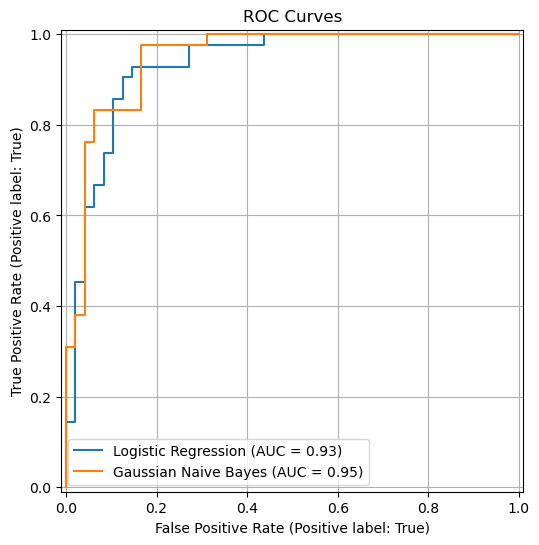

In [41]:
plot_roc_curves(results)


### Cross-Validation

In [42]:
def cross_validation(results, X, y, n_splits=5):
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    scores = []

    for r in results:
        cv_scores = cross_val_score(
        r['model'],
        X,
        y,
        cv=cv,
        scoring="accuracy"
    )
        print("=" * 80)
        print(f'{r['model_name']}\n')
        print("Cross-validated accuracy scores:", cv_scores)
        print("Mean CV accuracy:", cv_scores.mean().round(3), "+/-", cv_scores.std().round(3))


In [43]:
cross_validation(results, X, y)


Logistic Regression

Cross-validated accuracy scores: [0.91666667 0.85       0.74576271 0.84745763 0.83050847]
Mean CV accuracy: 0.838 +/- 0.055
Gaussian Naive Bayes

Cross-validated accuracy scores: [0.88333333 0.7        0.74576271 0.77966102 0.84745763]
Mean CV accuracy: 0.791 +/- 0.067


---
<div style="text-align: right; margin-top: 40px;">
<strong>Vladyslav Lysenko</strong> &nbsp;&nbsp; <strong>Parmida Mashadi Assadollahi</strong> &nbsp;&nbsp; <strong>Sankruththian Senathirajah</strong><br>
University of Toronto School of Continuing Studies<br>
November 2025
</div>